<a href="https://colab.research.google.com/github/andrewlee-29/Applied_Deep_Learning_2023Summer/blob/main/Week13_chapter12_part03_neural_style_transfer_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Neural style transfer

### The content loss

### The style loss

### Neural style transfer in Keras

The general process:

*   Set up a network that computes VGG19 layer activations for the style-reference image, the base image, and the generated image at the same time.
*   Use the layer activations computed over these three images to define the loss function described earlier, which we’ll minimize in order to achieve style transfer.
*   Set up a gradient-descent process to minimize this loss function.




Define the paths to the style-reference image and the base (content target) image.

Hint: widely different sizes make style transfer more difficult. Make sure images are similar size.
We wil resize them.


**Getting the style and content images**

In [ ]:
from tensorflow import keras

#Content Target Image
# base_image_path = "tree.jpg" #Note: You can upload an image and add it here w/o get_file
# base_image_path = keras.utils.get_file(
#     "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")

# Source: Travel and Leisure
# https://www.travelandleisure.com/travel-guide/boston
base_image_path = keras.utils.get_file(
    "boston-massachusetts-BOSTONTG0221.jpg", origin="https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F28%2F2021%2F02%2F23%2Fboston-massachusetts-BOSTONTG0221.jpg")

# Style Reference Image
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400 #resize
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 1s 1us/step


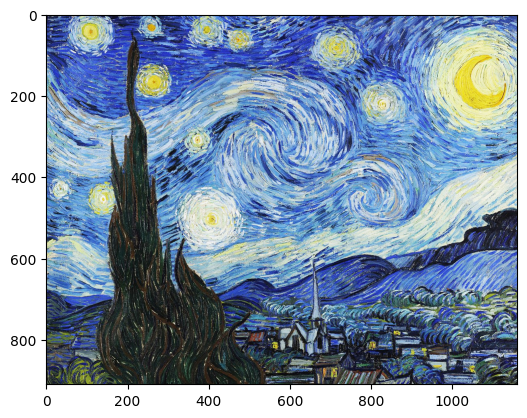

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

style_img = Image.open(style_reference_image_path)
plt.imshow(style_img);
# plt.axis('off');

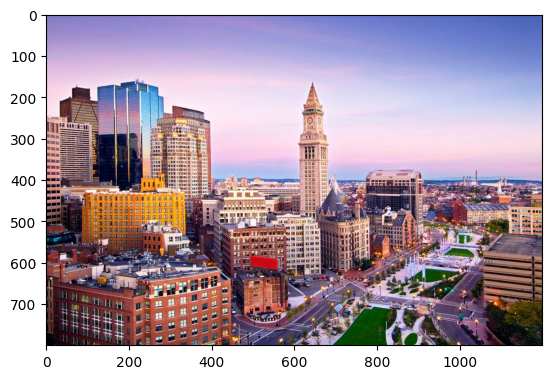

In [ ]:
#target_img / content image
target_img = Image.open(base_image_path)
plt.imshow(target_img);
# plt.axis('off');

# Source: Travel and Leisure
# https://www.travelandleisure.com/travel-guide/boston

**Auxiliary functions**

Auxiliary functions for loading, preprocessing, and postprocessing the images that go in and out of the VGG19 convnet

In [ ]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939 #reverse VGG preprocess_input
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Using a pretrained VGG19 model to create a feature extractor**

[VGG paper](https://arxiv.org/pdf/1409.1556.pdf)

[Keras tools for VGG](https://keras.io/api/applications/vgg/)

create a feature exactor model that returns the activations of intermediate layers


In [ ]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False) #drop the dense layers at the end

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
model.save("vgg19_notop.keras")
#can download and viz the model if you want.

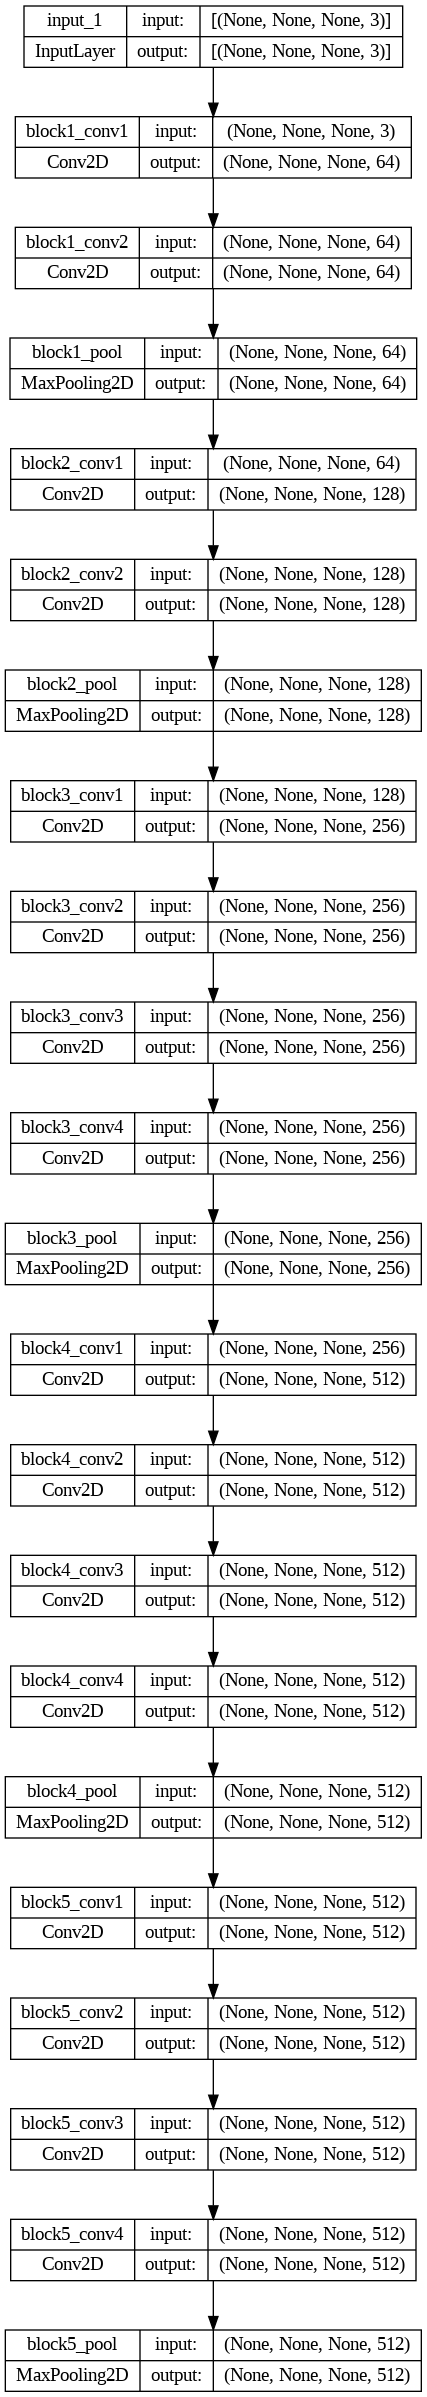

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Content loss**

makes sure the top layer of the VGG19 convnet has a similar view of the style image and the combination image.

In [ ]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(base_img-combination_img))

**Style loss**

Gram matrix of an input matrix: a map of the correlations found in the original feature matrix.

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
    #ME: Why not auto-correlation?

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Total variation loss**

> operates on the pixels of the generated combination image. It encourages spatial continuity in the generated image, thus avoiding overly pixelated results. You can interpret it as a regularization loss.

In [ ]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**Defining the final loss that you'll minimize**

> minimize is a weighted average of these three losses.

> To compute the content loss, you use only one upper layer— the `block5_conv2` layer

> for the style loss, you use a list of layers that spans both low-level and high-level layers.

> You add the total variation loss at the end.

In [ ]:
style_layer_names = [
    "block1_conv1", #64 filters
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1", #512
]

content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
# the contribution of the content loss to the total loss
content_weight = 2.5e-8 #tune me

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    #content_loss
    #TODO
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0,:,:,:]
    combination_image_features = layer_features[2,:,:,:]
    loss = loss + content_weight*content_loss(base_image_features, combination_image_features)

    # style_loss
    #TODO
    for layer_name in style_layer_names:
      layer_features = features[layer_name]
      combination_features = layer_features[2, :,:,:]
      style_features = layer_features[1, :,:,:]
      style_loss_value = style_loss(style_features,combination_features)
      loss += (style_weight / len(style_layer_names)) * style_loss_value

    # total_variation_loss
    #TODO
    loss += total_variation_weight * total_variation_loss(combination_image)

    return loss

**Note:**
> Tune the `content_weight` coefficient: Controls the contribution of the content loss to the total loss.

> A higher `content_weight` means the target content will be more recognizable in the generated image.

**Setting up the gradient-descent process**

Gatys' optimization algo not available. Do mini-batch gradient descent with the SGD optimizer instead.

New feature: ` learning-rate schedule`

> gradually decrease the learning rate from a very high value (100) to a much smaller final value (about 20). That way, we’ll make fast progress in the early stages of training and then proceed more cautiously as we get closer to the loss minimum.

In [ ]:
import tensorflow as tf

@tf.function #faster
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
        #decrease every 100 steps by 4%
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 2500 #4000
start = 1
for i in range(start, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=11095.31
Iteration 200: loss=8740.91
Iteration 300: loss=7818.16
Iteration 400: loss=7306.48
Iteration 500: loss=6971.83
Iteration 600: loss=6731.03
Iteration 700: loss=6546.24
Iteration 800: loss=6398.21
Iteration 900: loss=6276.05
Iteration 1000: loss=6172.68
Iteration 1100: loss=6084.09
Iteration 1200: loss=6007.30
Iteration 1300: loss=5939.76
Iteration 1400: loss=5880.03
Iteration 1500: loss=5826.87
Iteration 1600: loss=5779.44
Iteration 1700: loss=5736.76
Iteration 1800: loss=5698.17
Iteration 1900: loss=5663.08
Iteration 2000: loss=5631.09
Iteration 2100: loss=5601.77
Iteration 2200: loss=5574.87
Iteration 2300: loss=5550.11
Iteration 2400: loss=5527.31
Iteration 2500: loss=5506.26


### Wrapping up

Really a 'texture transfer'. closer to classical signal processing than to AI.

> works best:
> with style-reference images that are strongly textured and highly self-similar, and
> with content targets that don’t require high levels of detail in order to be recognizable.



## Give it a go!

Pair with a classmate and try your own images!